# Kmeans

- Preprocessing part
- Modeling
- Evaluating
- Conclusion

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import shap

from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.compose._column_transformer import ColumnTransformer

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

In [7]:
# Read data file
df = pd.read_csv('../data/train.csv', sep=";")
df.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

In [8]:
df = df.iloc[:, 0:8]
df.head()

age           job  marital  education default  balance housing loan
0   58    management  married   tertiary      no     2143     yes   no
1   44    technician   single  secondary      no       29     yes   no
2   33  entrepreneur  married  secondary      no        2     yes  yes
3   47   blue-collar  married    unknown      no     1506     yes   no
4   33       unknown   single    unknown      no        1      no   no

## Preprocessing part

- Convert categorical variables into numeric ones - Onehot encoder + Ordinal encoder
- Ensure numerical variables having a Guassian distribution - PowerTransformer


In [14]:
categorical_transformer_onehot = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False))
    ]
)

categorical_transformer_ordinal = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder())
    ]
)

num = Pipeline(
    steps=[
        ("encoder", PowerTransformer())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_onehot', categorical_transformer_onehot, ["default", "housing", "loan", "job", "marital"]),
        ('cat_ordinal', categorical_transformer_ordinal, ["education"]),
        ('num', num, ["age", "balance"])
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor)
    ]
)
pip_fit = pipeline.fit(df)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [15]:
data = pd.DataFrame(
    pip_fit.transform(df),
    columns=pip_fit.get_feature_names_out().tolist()
)
data.head()

cat_onehot__default_yes  cat_onehot__housing_yes  cat_onehot__loan_yes  \
0                      0.0                      1.0                   0.0   
1                      0.0                      1.0                   0.0   
2                      0.0                      1.0                   1.0   
3                      0.0                      1.0                   0.0   
4                      0.0                      0.0                   0.0   

   cat_onehot__job_blue-collar  cat_onehot__job_entrepreneur  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          0.0                           1.0   
3                          1.0                           0.0   
4                          0.0                           0.0   

   cat_onehot__job_housemaid  cat_onehot__job_management  \
0                        0.0                         1.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        0.0                         0.0   

   cat_onehot__job_retired  cat_onehot__job_self-employed  \
0                      0.0                            0.0   
1                      0.0                            0.0   
2                      0.0                            0.0   
3                      0.0                            0.0   
4                      0.0                            0.0   

   cat_onehot__job_services  cat_onehot__job_student  \
0                       0.0                      0.0   
1                       0.0                      0.0   
2                       0.0                      0.0   
3                       0.0                      0.0   
4                       0.0                      0.0   

   cat_onehot__job_technician  cat_onehot__job_unemployed  \
0                         0.0                         0.0   
1                         1.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   cat_onehot__job_unknown  cat_onehot__marital_married  \
0                      0.0                          1.0   
1                      0.0                          0.0   
2                      0.0                          1.0   
3                      0.0                          1.0   
4                      1.0                          0.0   

   cat_onehot__marital_single  cat_ordinal__education  num__age  num__balance  
0                         0.0                     2.0  1.473637      0.414773  
1                         1.0                     1.0  0.429379     -0.410774  
2                         0.0                     1.0 -0.709873     -0.431122  
3                         0.0                     3.0  0.683128      0.197685  
4                         1.0                     3.0 -0.709873     -0.432119

In [16]:
data.columns.tolist()

['cat_onehot__default_yes',
 'cat_onehot__housing_yes',
 'cat_onehot__loan_yes',
 'cat_onehot__job_blue-collar',
 'cat_onehot__job_entrepreneur',
 'cat_onehot__job_housemaid',
 'cat_onehot__job_management',
 'cat_onehot__job_retired',
 'cat_onehot__job_self-employed',
 'cat_onehot__job_services',
 'cat_onehot__job_student',
 'cat_onehot__job_technician',
 'cat_onehot__job_unemployed',
 'cat_onehot__job_unknown',
 'cat_onehot__marital_married',
 'cat_onehot__marital_single',
 'cat_ordinal__education',
 'num__age',
 'num__balance']

⚠️ KMeans is very sensitive with **outliers**. In this notebook, we'll use the Python Outlier Detection (PyOD) lib with **ECOD (empirical cumulative distribution functions for outlier detection)** to resolve the problem.

tl;dr: This method seeks to obtain the distribution of the data and thus know which are the values where the probability density is lower (aka "outliers").

In [17]:
clf = ECOD()
clf.fit(data)
outliers = clf.predict(data)

data["outliers"] = outliers
data.head()

cat_onehot__default_yes  cat_onehot__housing_yes  cat_onehot__loan_yes  \
0                      0.0                      1.0                   0.0   
1                      0.0                      1.0                   0.0   
2                      0.0                      1.0                   1.0   
3                      0.0                      1.0                   0.0   
4                      0.0                      0.0                   0.0   

   cat_onehot__job_blue-collar  cat_onehot__job_entrepreneur  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          0.0                           1.0   
3                          1.0                           0.0   
4                          0.0                           0.0   

   cat_onehot__job_housemaid  cat_onehot__job_management  \
0                        0.0                         1.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        0.0                         0.0   

   cat_onehot__job_retired  cat_onehot__job_self-employed  \
0                      0.0                            0.0   
1                      0.0                            0.0   
2                      0.0                            0.0   
3                      0.0                            0.0   
4                      0.0                            0.0   

   cat_onehot__job_services  cat_onehot__job_student  \
0                       0.0                      0.0   
1                       0.0                      0.0   
2                       0.0                      0.0   
3                       0.0                      0.0   
4                       0.0                      0.0   

   cat_onehot__job_technician  cat_onehot__job_unemployed  \
0                         0.0                         0.0   
1                         1.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   cat_onehot__job_unknown  cat_onehot__marital_married  \
0                      0.0                          1.0   
1                      0.0                          0.0   
2                      0.0                          1.0   
3                      0.0                          1.0   
4                      1.0                          0.0   

   cat_onehot__marital_single  cat_ordinal__education  num__age  num__balance  \
0                         0.0                     2.0  1.473637      0.414773   
1                         1.0                     1.0  0.429379     -0.410774   
2                         0.0                     1.0 -0.709873     -0.431122   
3                         0.0                     3.0  0.683128      0.197685   
4                         1.0                     3.0 -0.709873     -0.432119   

   outliers  
0         0  
1         0  
2         0  
3         0  
4         1

In [19]:
data_no_outliers = data[data["outliers"] == 0] # only get row where data['outliers'] = 0
data_no_outliers = data_no_outliers.drop(["outliers"], axis=1) # drop the 'outliers' column

data_with_outliers = data.copy()
data_with_outliers = data_with_outliers.drop(["outliers"], axis=1)

print(data_no_outliers.shape)
print(data_with_outliers.shape)

(40690, 19)
(45211, 19)


## Modeling

⚠️ One of the disadvantages of using the KMeans algo is that **you must choose the number of clusters you want to use**. In this notebook, we'll use the Elbow Method to determine this value.

tl;dr This method consists of calculating **the distorsion** that exists between the points of a cluster and its centroid. The objective is clear, to obtain **the least possible distortion**.

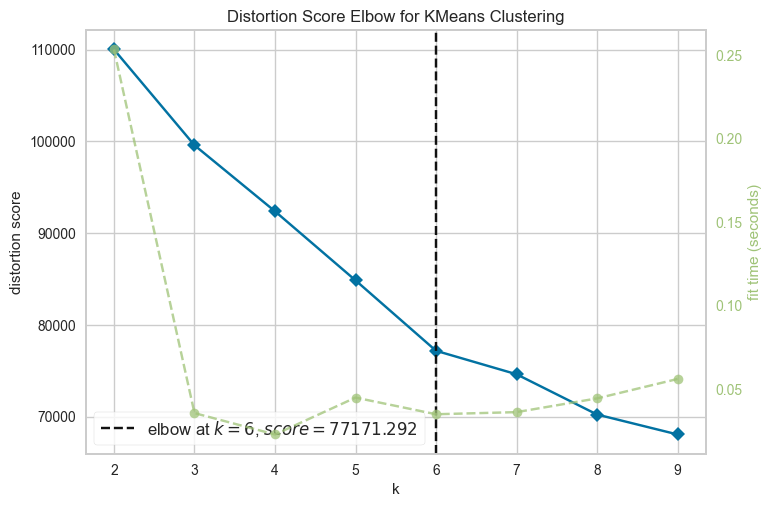

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
# Instantiate the clustering model and visualizer
km = KMeans(init='k-means++', random_state=0, n_init='auto')
visualizer = KElbowVisualizer(km, k=(2, 10))

visualizer.fit(data_no_outliers)
visualizer.show()

💭 We see that from `k=6`, the distorsion does not vary drastically. It is true that the ideal is that the behavior starting from `k=6`. To be sure, we could perform a Silhoutte visualization

In [21]:
def make_Silhoutte_plot(X, n_clusters):
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, n_init=10, init='k-means++', random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg,
    )

    # Compute the silhoutte scores for each sample
    samples_silhoutte_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhoutte_values = samples_silhoutte_values[cluster_labels == i]
        ith_cluster_silhoutte_values.sort()

        size_cluster_i = ith_cluster_silhoutte_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhoutte_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        plt.title(f"The Silhouette Plot for n_cluster = {n_clusters}", fontsize=26)
        plt.xlabel("The silhouette coefficient values", fontsize=24)
        plt.ylabel("Cluster label", fontsize=24)
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.yticks([])  
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [22]:
# Running this cell was time-consumming
range_n_clusters = list(range(2, 10))
for n_clusters in range_n_clusters:
    print(f"N cluster: {n_clusters}")
    make_Silhoutte_plot(data_no_outliers, n_clusters)
    plt.savefig('../images/Silhouette_plot_{}.png'.format(n_clusters))
    plt.close()

N cluster: 2
For n_clusters = 2 The average silhouette_score is : 0.1811128736615612
N cluster: 3
For n_clusters = 3 The average silhouette_score is : 0.16787543108034594
N cluster: 4
For n_clusters = 4 The average silhouette_score is : 0.15834119588807355
N cluster: 5
For n_clusters = 5 The average silhouette_score is : 0.1672987260052538
N cluster: 6
For n_clusters = 6 The average silhouette_score is : 0.1548509850625821
N cluster: 7
For n_clusters = 7 The average silhouette_score is : 0.14953076421820127
N cluster: 8
For n_clusters = 8 The average silhouette_score is : 0.15098396457075325
N cluster: 9
For n_clusters = 9 The average silhouette_score is : 0.1484291730353649


💭 According to the visualizations, there seems to be no very clear decision as to which number is best 😂😂😂. We'll stick the `k=6` in this notebook

In [43]:
# Recall
print(type(data_no_outliers), data_no_outliers.shape)

<class 'pandas.core.frame.DataFrame'> (40690, 19)


In [24]:
km = KMeans(
    n_clusters=6,
    init='k-means++',
    n_init=10,
    max_iter=100,
    random_state=42
)
clusters_predict = km.fit_predict(data_no_outliers)

"""
clusters_predict -> array([4, 2, 0, ..., 3, 4, 3])
np.unique(clusters_predict) -> array([0, 1, 2, 3, 4])
"""

'\nclusters_predict -> array([4, 2, 0, ..., 3, 4, 3])\nnp.unique(clusters_predict) -> array([0, 1, 2, 3, 4])\n'

## Evaluation

The way of evaluating KMeans models is somewhat more open that for other models. We can use
- metrics
- visualizations
- interpretation

In [25]:
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure 
of each cluster with its most similar cluster, where similarity 
is the ratio of within-cluster distances to between-cluster distances.

The minimum value of the DB Index is 0, whereas a smaller 
value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(data_no_outliers, clusters_predict)}")

Davies bouldin score: 1.7349424571558956


In [27]:
from sklearn.metrics import calinski_harabasz_score

"""
Calinski Harabaz Index -> Variance Ratio Criterion.

Calinski Harabaz Index is defined as the ratio of the 
sum of between-cluster dispersion and of within-cluster dispersion.

The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(data_no_outliers,clusters_predict)}")

Calinski Score: 6277.214971680761


In [28]:
"""
The silhouette score is a metric used to calculate the goodness of 
fit of a clustering algorithm, but can also be used as 
a method for determining an optimal value of k (see here for more).

Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either
the data or the value of k is incorrect.

1 is the ideal value and indicates that clusters are very 
dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(data_no_outliers,clusters_predict)}")

Silhouette Score: 0.154850460839958


💭 As far as can be shown, we **do not** have an excessively good model. **Davie'score** is telling us that the distance between clusters is quite small. This may be due to several factors, but keep in mind that the energy of a model is the data; if the data does not have sufficient predictive power, you cannot expect to achieve exceptional results.

For visualizations, we can use the methode to reduce dimensionality, PCA.

In [44]:
import sys  
sys.path.insert(1, '../src/')

from visualize import get_pca_nd, plot_pca_3d

In [32]:
pca_3d_object, df_pca_3d = get_pca_nd(data_no_outliers, clusters_predict, ndim=3)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0              2.245        11.81%                     11.81%
1              1.774         9.34%                     21.15%
2              1.298         6.83%                     27.98%


💭 It can be seen that the clusters have almost no separation between them and there is no clear division.

**✍️ Something to keep in mind and that very few people keep in mind is the PCA and the variability of the eigenvectors.**

Each field or component in the PCA analysis contains a certain amount of information. Think of these fields as aspects or features of the data that are being considered. In PCA, the technique identifies the most important components (eigenvectors) and ranks them by their contribution to the variability in the data.

If the accumulated sum of the 3 main components adds up to around 80% variability, we can say that it is acceptable, obtaining good results in the representations. In other words, these 3 components capture a large portion of the data's structure and patterns, and the results obtained from visualizing the data using these components will likely be meaningful. However, if it is not the case, it means that a significant amount of information is still unaccounted for.

As can be seen, we have `27.98%` variability with the first 3 components, something insufficient to draw informed conclusions.

When we apply PCA method, since it is **linear algorithm**, it is not capable of capturing more complex relationships. Luckily there is a method called **t-SNE**, which is capable of capturing *these complex polynomial relationships*. 

In [33]:
# Running this cell is completely a time-intensive task even when we sampled the original dataset !!!
sampling_data = data_no_outliers.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=1)[0].values

df_tsne_3d = TSNE(
    n_components=3,
    learning_rate=500,
    init='random',
    perplexity=200,
    n_iter=5000
).fit_transform(sampling_data)

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=['comp1', 'comp2', 'comp3'])
df_tsne_3d["cluster"] = sampling_clusters
plot_pca_3d(df_tsne_3d, title = "PCA Space", opacity=1, width_line = 0.1)

💭 As a result, it shows a clearer seperation between clusters but unfortunately, we still don't have good results.

Finally, let's explore a little how the model works, in which features are the most important and what are the main characteristics of the clusters.
To see the important of each of the variables we will use a typical "trick" in this type of situation. We are going to create a classification model where `X` is the inputs of the KMeans model and `y` is the clusters predicted by the KMeans model.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 40690, number of used features: 19
[LightGBM] [Info] Start training from score -1.328197
[LightGBM] [Info] Start training from score -1.910563
[LightGBM] [Info] Start training from score -1.792005
[LightGBM] [Info] Start training from score -1.482549
[LightGBM] [Info] Start training from score -2.872204
[LightGBM] [Info] Start training from score -1.989306


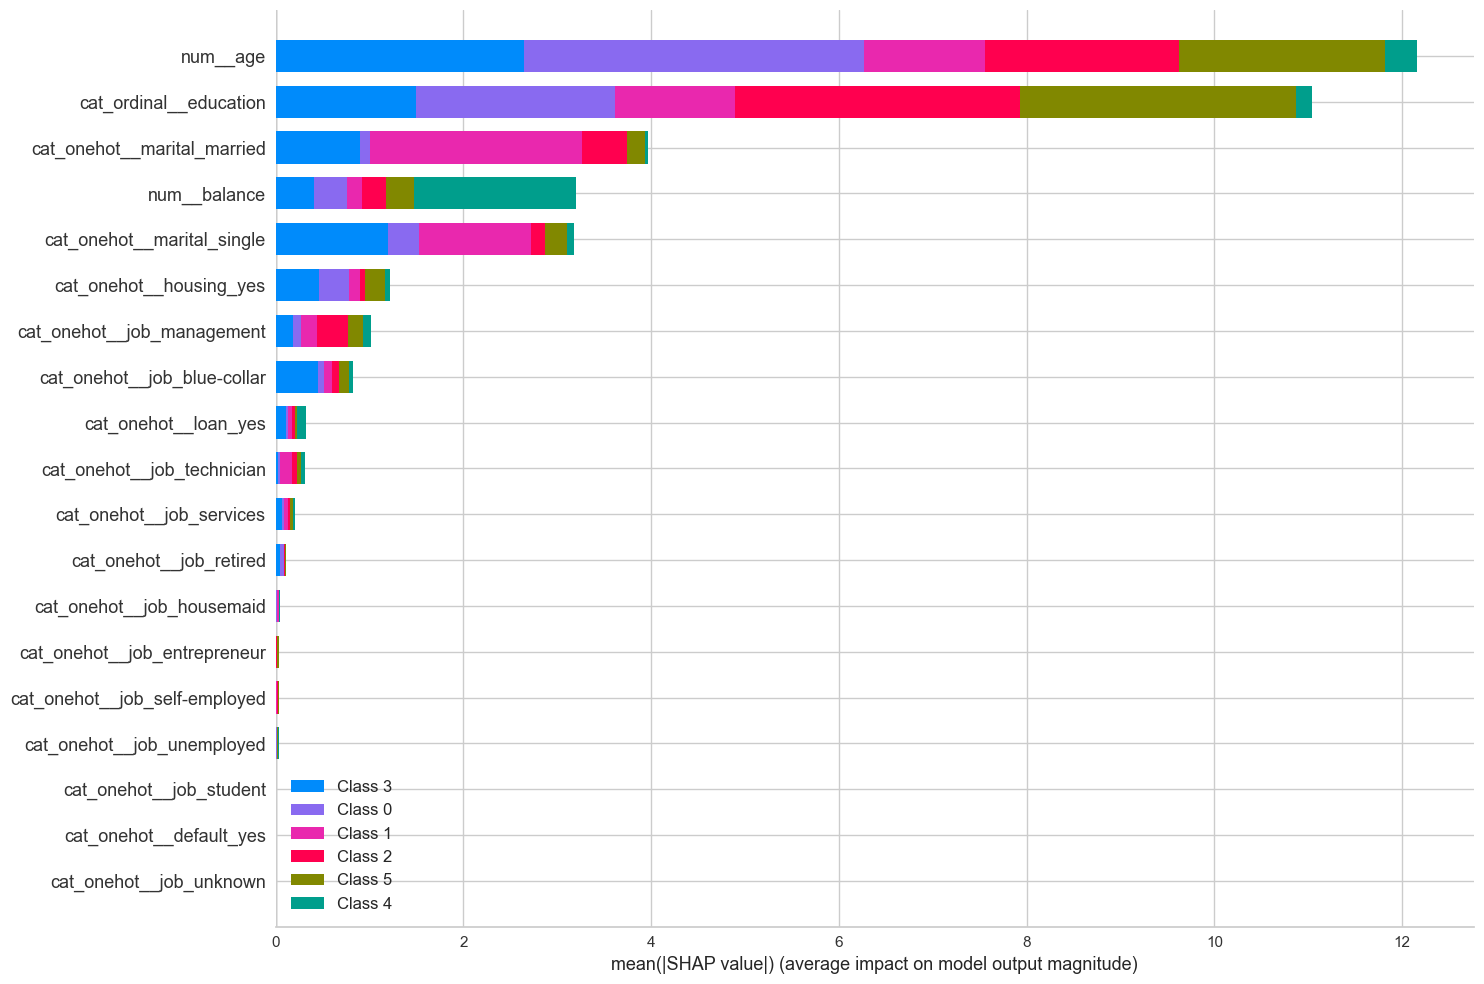

In [34]:
# The chosen model is an LGBMClassifier.
clf_lgb = lgb.LGBMClassifier(colsample_bytree=0.8)
clf_lgb.fit(X=data_no_outliers, y=clusters_predict)

explained_km = shap.TreeExplainer(clf_lgb)
shap_values_km = explained_km.shap_values(data_no_outliers)
shap.summary_plot(shap_values_km, data_no_outliers, plot_type="bar", plot_size=(15, 10))

Finally, we must analyze the characteristics of the clusters. This part of study is what is decisive for the business.

In [41]:
df_no_outliers = df[data['outliers'] == 0]
df_no_outliers["cluster"] = clusters_predict

df_no_outliers.groupby('cluster').agg({
    'job': lambda x: x.value_counts().index[0],
    'marital': lambda x: x.value_counts().index[0],
    'education': lambda x: x.value_counts().index[0],
    'housing': lambda x: x.value_counts().index[0],
    'loan': lambda x: x.value_counts().index[0],
    'age':'mean',
    'balance': 'mean',
    'default': lambda x: x.value_counts().index[0],
}).reset_index()

C:\Users\xuanh\AppData\Local\Temp\ipykernel_25028\2420448318.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster          job  marital  education housing loan        age  \
0        0  blue-collar  married  secondary      no   no  50.450793   
1        1   technician   single  secondary     yes   no  32.435071   
2        2   management   single   tertiary     yes   no  32.881563   
3        3  blue-collar  married  secondary     yes   no  35.119710   
4        4   management  married  secondary     yes   no  42.079062   
5        5   management  married   tertiary      no   no  48.005210   

       balance default  
0   845.496058      no  
1   695.431418      no  
2   886.751180      no  
3   603.337374      no  
4  7688.526064      no  
5   940.708947      no

## Conclusion
After carrying out the analysis in different ways, they converge on the same conclusion: **We need to improve the results**.